In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, MaxPool1D, Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MSE
from tensorflow.keras.regularizers import L2
from tensorflow.keras.initializers import he_normal, glorot_uniform
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from visualization_utility import plot_data
from prepare_NN_data import prepare_data
from NN_model_plots import plot_learning_curve, plot_random, plot_relative_errors, plot_errors_hist
import h5py
import os
import sys


2024-07-31 13:49:12.604345: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-31 13:49:12.642283: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 13:49:12.642297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 13:49:12.643288: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 13:49:12.649498: I tensorflow/core/platform/cpu_feature_guar

[NbConvertApp] Converting notebook visualization_utility.ipynb to script
[NbConvertApp] Writing 7407 bytes to visualization_utility.py
[NbConvertApp] Converting notebook prepare_NN_data.ipynb to script
[NbConvertApp] Writing 8260 bytes to prepare_NN_data.py
[NbConvertApp] Converting notebook NN_model_plots.ipynb to script
[NbConvertApp] Writing 5394 bytes to NN_model_plots.py


In [2]:
print(tf.__version__)

2.15.0


<h3>Load the data</h3>

In [3]:
# Folder where the input and output data are located
NN_data_path = "/fmi/projappl/project_2004400/jamin/data/libradtran_data/NN_data/"

In [4]:
data_dict = prepare_data(NN_data_path=NN_data_path,
                         output_var="tdir_up",
                         train_prop=0.8,
                         val_prop=0.1,
                         test_prop=0.1)

2024-07-31 13:50:58.376158: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
data_dict.keys()

dict_keys(['scaled_X_train', 'scaled_X_val', 'scaled_X_test', 'Y_train_tdir_up', 'Y_val_tdir_up', 'Y_test_tdir_up'])

In [6]:
scaled_X_train = data_dict["scaled_X_train"]
scaled_X_val = data_dict["scaled_X_val"]
scaled_X_test = data_dict["scaled_X_test"]
Y_train_tdir_up = data_dict["Y_train_tdir_up"]
Y_val_tdir_up = data_dict["Y_val_tdir_up"]
Y_test_tdir_up = data_dict["Y_test_tdir_up"]

In [7]:
print("############### Training data ###############")
print(f"Shape of scaled_X_train: {scaled_X_train.shape}")
print(f"Shape of Y_train_tdir_up: {Y_train_tdir_up.shape}")
print()
print("############### Validation data ###############")
print(f"Shape of scaled_X_val: {scaled_X_val.shape}")
print(f"Shape of Y_val_tdir_up: {Y_val_tdir_up.shape}")
print()
print("############### Test data ###############")
print(f"Shape of scaled_X_test: {scaled_X_test.shape}")
print(f"Shape of Y_test_tdir_up: {Y_test_tdir_up.shape}")

############### Training data ###############
Shape of scaled_X_train: (1382, 53, 1)
Shape of Y_train_tdir_up: (1382, 235002)

############### Validation data ###############
Shape of scaled_X_val: (172, 53, 1)
Shape of Y_val_tdir_up: (172, 235002)

############### Test data ###############
Shape of scaled_X_test: (174, 53, 1)
Shape of Y_test_tdir_up: (174, 235002)


In [8]:
tdir_up_max = np.max(np.vstack([Y_train_tdir_up.numpy(), Y_val_tdir_up.numpy(), Y_test_tdir_up.numpy()]))
tdir_up_min = np.min(np.vstack([Y_train_tdir_up.numpy(), Y_val_tdir_up.numpy(), Y_test_tdir_up.numpy()])) 
print(f"Range of tdir_up: [{tdir_up_min}, {tdir_up_max}]")

Range of tdir_up: [0.0, 0.9323679804801941]


<h3>Train the model</h3>

In [9]:
def model(X_train, Y_train, X_val, Y_val, num_epochs: int, batch_size: int, output_var_name):
    """
    Builds, compiles, fits the neural network model. 
    
    Args:
    X -- the input dataset
    Y -- the output dataset
    num_epochs -- the number of epochs
    batch_size -- the batch size
    val_data -- validation data to be used in the training process of the NN
    output_var_name -- name of the output variable that the NN model predicts
    
    Prints:
    - train MSE
    - validation MSE
    
    Returns:
    model -- the fitted neural network model.
    loss_history -- the loss history of the fitted neural network model.
    """
    #tf.random.set_seed(42)
    
    # Architecture of the NN model
    model = Sequential([
        
        Input(shape=(53, 1)),
        
        # Hidden layer 1
        Conv1D(filters=10, kernel_size=3, kernel_initializer=he_normal(), activation="relu"),
        
        # Hidden layer 2
        MaxPool1D(pool_size=2, strides=None),
        
        # Flatten the 3D tensor into a 1D vector
        Flatten(),
        
        # Hidden layer 3
        Dense(units=60, kernel_initializer=he_normal(), activation="relu"),
        
        # Hidden layer 4
        Dense(units=60, kernel_initializer=he_normal(), activation="relu"),

        # Output layer
        Dense(units=235002, kernel_initializer=glorot_uniform(), activation="linear"),
    ])
    
    # Compile the model
    model.compile(loss=MSE,
                  optimizer=Adam(),
                  metrics=["mse"])
    
    # Fit the model
    loss_history = model.fit(X_train, 
                             Y_train, 
                             epochs=num_epochs, 
                             batch_size=batch_size, 
                             validation_data=(X_val, Y_val))
    
    # Train error
    train_loss, train_mse = model.evaluate(X_train, Y_train)
    
    # Validation error
    val_loss, val_mse = model.evaluate(X_val, Y_val)
    
    print("########################################")
    print(f"Train MSE: {train_mse}")
    print(f"Validation MSE: {val_mse}")
    print("########################################")
    
    return model, loss_history

In [13]:
NN_model, loss_history = model(X_train=scaled_X_train, 
                               Y_train=Y_train_tdir_up,
                               X_val=scaled_X_val,
                               Y_val=Y_val_tdir_up,
                               num_epochs=25,
                               batch_size=32,
                               output_var_name="tdir_up")

Epoch 1/25
44/44 [==============================] - 3s 45ms/step - loss: 0.2101 - mse: 0.2101 - val_loss: 0.0326 - val_mse: 0.0326
Epoch 2/25
44/44 [==============================] - 2s 42ms/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 3/25
44/44 [==============================] - 2s 42ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0061 - val_mse: 0.0061
Epoch 4/25
44/44 [==============================] - 2s 42ms/step - loss: 0.0031 - mse: 0.0031 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 5/25
44/44 [==============================] - 2s 43ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 8.0372e-04 - val_mse: 8.0372e-04
Epoch 6/25
44/44 [==============================] - 2s 44ms/step - loss: 6.9894e-04 - mse: 6.9894e-04 - val_loss: 5.6533e-04 - val_mse: 5.6533e-04
Epoch 7/25
44/44 [==============================] - 2s 43ms/step - loss: 5.0183e-04 - mse: 5.0183e-04 - val_loss: 4.5402e-04 - val_mse: 4.5402e-04
Epoch 8/25
44/44 [=========================

<h3>Plotting</h3>

Note that:

- The term **'true'** in the plots refers to the output values obtained from libradtran RT model.
- The term **'emulated'** refers to the predicted values obtained from the fitted neural network model.

In [14]:
tdir_up_preds = NN_model.predict(scaled_X_val)

6/6 [==============================] - 0s 4ms/step


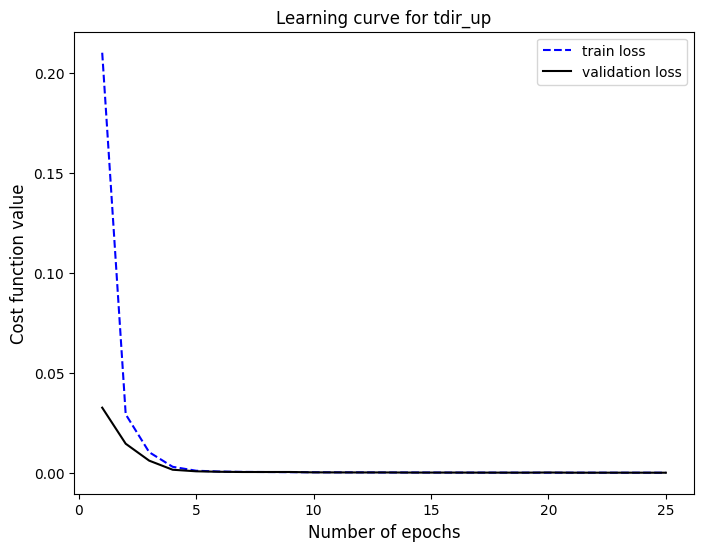

In [15]:
plot_learning_curve(loss_history, "tdir_up")

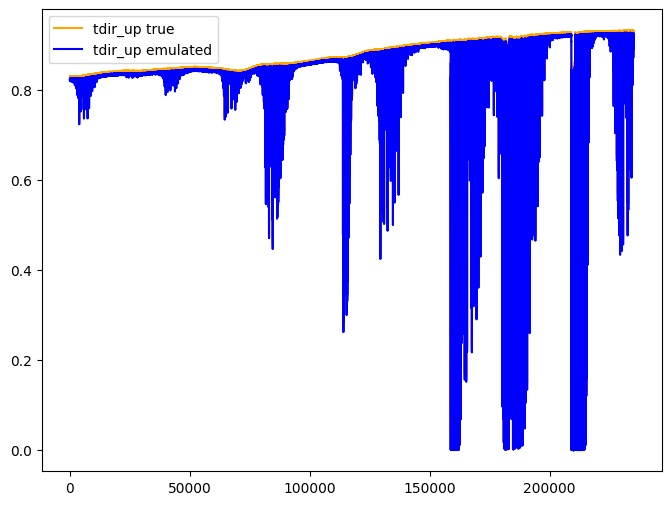

In [16]:
plot_random(tdir_up_preds, scaled_X_val, Y_val_tdir_up, "tdir_up")

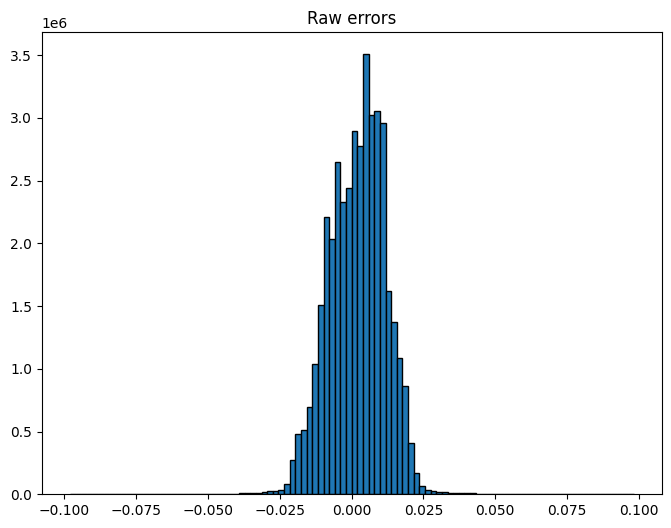

In [18]:
plot_errors_hist(tdir_up_preds, scaled_X_val, Y_val_tdir_up)

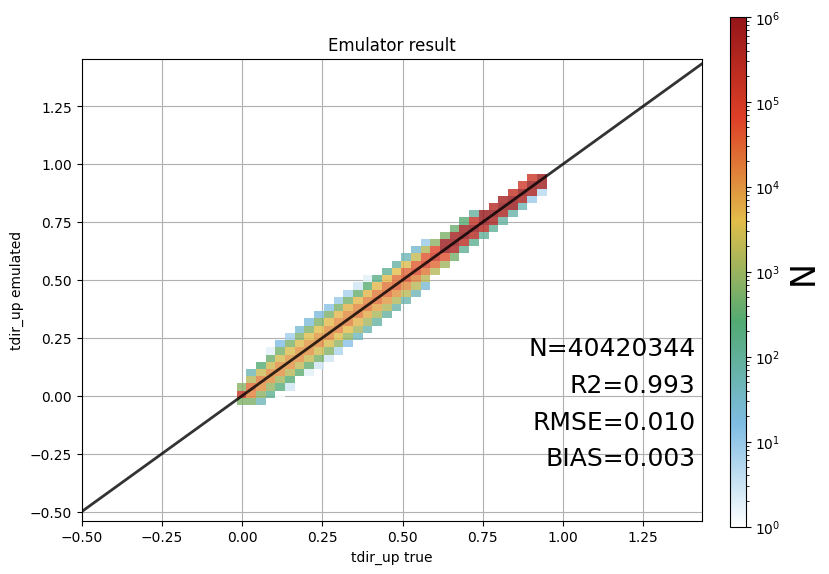

In [19]:
# Plot emulator results vs. true (libradtran RT model) values
plot_data(y_true=Y_val_tdir_up,
          y_pred=tdir_up_preds,
          title="Emulator result",
          x_label="tdir_up true",
          y_label="tdir_up emulated",
          error_bar_on=True)

<h3>Errors</h3>

Errors are calculated as $\, Y_{preds} - Y_{true}. \,$ This means that 

- if the error is positive, the model prediction is larger than the true value
- if the error is negative, the model prediction is smaller than the true value.

<h3>Bias</h3>

Bias is calculated as $\, \text{median} (Y_{preds} - Y_{true}). \,$ This means that 
- if $\, \text{Bias} > 0, \,$ the predicted values are generally larger than the true values \
$\, \boldsymbol{\rightarrow} \,$ the model systematically **overestimates** the predicted values
- if $\, \text{Bias} < 0, \,$ the predicted values are generally smaller than the true values \
$\, \boldsymbol{\rightarrow} \,$ the model systematically **underestimates** the predicted values